# The Mapillary Traffic Sign Dataset for Detection and Classification on a Global Scale - paper review

## Challenges
- traffic signs are easily confused with other object classes in street
- reflection, low light condition, damages, and occlusion
- fine–grained classification
- traffic signs are relatively small in size

## Dataset Statistics
- images: 52,453 fully-anotated 47,547 partialy-anotated
- sign categories: 313 + 1 (other sign)
- total signs: 257 543

| train  | dev   | test   |
|--------|-------|--------|
| 36 589 | 5 320 | 10 544 |

- distribution plots are present in the paper

##  Annotation Process 
The annotations were done by 15 experts trained on this task. The authors continuously controlled the quality of annotations. At least two annotators must have seen each image. To further validate the quality of annotations, they runed separate annotation experiment over smaller subset of images and cross-checked the results showing only minor differences.

### 1. Selection
The images were selected using the following criteria:
- uniform geographical distribution of images around the world (weighted by continent population)
- to cover images of different quality, captured under varying conditions
- to include as many signs as possible per image
- to compensate for the long-tailed distribution of potential traffic
sign classes

### 2. Annotation
The annotation pipeline consisted of 3 steps:
1. Image Approval: the annotators should have ensured that the data fulfil the dataset criteria since the pre-selection was automatically
2. Sign Localization: The bounding boxes were pre-generated automatically. The annotators were asked to verify and adjust the bounding boxes to fit all traffic signs in the image.
3. Sign Classification: The annotators were asked to provide a correct class label for show sign (determined by box). This was not trivial since they used 313 classes. Thereby, the signs were pre-annotated automatically using a proposal network.

## Baseline
- Faster R-CNN with ResNet50 and ResNet101 back-bones
- two tasks: detection only and detection + classification
- ResNet50: 83.4 mAP over all 313 classes
- their best performing approach used 2 stage pipeline: 1. binary object detection, 2. multi-class classification using a decoupled shallow classification network


In [1]:
import os
import numpy as np
import json
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
PATH = "C:\\Users\\tlust\\Downloads\\mtsd"
SINGLE_STEP = True
DOUBLE_STEP = False

# input files
splits_path = os.path.join(PATH, "splits")
images_path = os.path.join(PATH, "images")
annotations_path = os.path.join(PATH, "annotations")

# output files
output_path = os.path.join(PATH, "yolov8")

# YOLOv8 parser

## One-step fully taxonomy detection + classification to 313 classes
Initial experiment to assess the model's default performance across the entire taxonomy. Anticipated to yield suboptimal results due to the extensive number of classes.

In [3]:
if SINGLE_STEP:
    labels = []

    # statistics
    rejected = 0
    total = 0
    sign_distr = {}

    test = 0

    for split in ['train', 'val', 'test']:
        print("Processing {} split...".format(split))

        # 0. create output directories if not exists
        out_dir = os.path.join(output_path, split)
        if not os.path.exists(out_dir):
            os.makedirs(os.path.join(out_dir, "images"))
            os.makedirs(os.path.join(out_dir, "labels"))

        with open(os.path.join(splits_path, split + ".txt")) as f:
            ids = f.readlines()

        for id in tqdm(ids, total=len(ids)):
            total += 1    

            # 1. set and validate paths
            id = id.strip()
            img_path = os.path.join(images_path, f"{id}.jpg")
            ann_path = os.path.join(annotations_path, f"{id}.json")
            out_img_path = os.path.join(out_dir, "images", f"{id}.jpg")
            out_ann_path = os.path.join(out_dir, "labels", f"{id}.txt")  
    
            # 1.2. skip if image or annotation does not exists
            if (not os.path.exists(img_path)) or (not os.path.exists(ann_path)):
                rejected += 1
                continue

            if split == 'test':
                test += 1

            # 2. copy the image
            shutil.copy(img_path, out_img_path)

            # 3. create YOLOv8 annotation
            with open(ann_path, 'r') as f:
                ann = json.load(f)
                
            with open(out_ann_path, "a") as f:  
                for obj in ann['objects']:
                    # 3.1 get label index
                    if obj['label'] not in labels:
                        labels.append(obj['label'])
                    label = labels.index(obj['label'])

                    # 3.2 set sign distribution
                    sign_distr[label] = sign_distr[label] + 1 if label in sign_distr else 1

                    # 3.3 get bounding box
                    bbox = obj['bbox']
                    x_center = np.clip(((bbox['xmin'] + bbox['xmax']) / 2) / ann['width'], 0, 1)
                    y_center = np.clip(((bbox['ymin'] + bbox['ymax'] ) / 2) / ann['height'], 0, 1)
                    width = np.clip((bbox['xmax'] - bbox['xmin']) / ann['width'], 0, 1)
                    height = np.clip((bbox['ymax'] - bbox['ymin']) / ann['height'], 0, 1)
                    obj_ann = f"{label} {x_center} {y_center} {width} {height} \n"

                    # 3.4 write annotation
                    f.write(obj_ann)

    # 4. create dataset.yaml
    with open(os.path.join(output_path, "dataset.yaml"), "a") as f:
        f.write("path: .\n")
        f.write(f"train: {os.path.join('train', 'images')}\n")
        f.write(f"val: {os.path.join('train', 'images')}\n")
        f.write(f"names:\n")
        for ix, label in enumerate(labels):
            f.write(f"  {ix}: {label}\n")

Processing train split...


100%|██████████| 36589/36589 [21:20<00:00, 28.57it/s]


Processing val split...


100%|██████████| 5320/5320 [03:53<00:00, 22.75it/s]


Processing test split...


100%|██████████| 10544/10544 [00:02<00:00, 4114.21it/s]


## 2-stage pipeline
Anticipated to yield improved outcomes as a result of decoupling.

In [ ]:
if DOUBLE_STEP:
    labels = []

    # statistics
    rejected = 0
    total = 0
    sign_distr = {}


    for split in ['train', 'val', 'test']:
        print("Processing {} split...".format(split))
   
        with open(os.path.join(splits_path, split + ".txt")) as f:
            ids = f.readlines()

        for id in tqdm(ids, total=len(ids)):
            total += 1

            # 1. set and validate paths
            id = id.strip()
            img_path = os.path.join(images_path, f"{id}.jpg")
            ann_path = os.path.join(annotations_path, f"{id}.json")
    
            # 1.2. skip if image or annotation does not exists
            if (not os.path.exists(img_path)) or (not os.path.exists(ann_path)):
                rejected += 1
                continue

            # 2. load the image
            img = cv2.imread(img_path)

            # 3. extract traffic sign and create classification dataset                
            for obj in ann['objects']:

                # 3.1 get sign path and create directory if not exists
                sign_dir = os.path.join(output_path, split, obj['label'])
                if not os.path.exists(sign_dir):
                    os.makedirs(sign_dir)

                # 3.2 increment sign counter
                if  obj['label'] not in labels:
                    labels.append(obj['label'])
                label = labels.index(obj['label'])            
                sign_distr[label] = sign_distr[label] + 1 if label in sign_distr else 1

                # 3.3 get bounding box
                sign = img[
                    obj['bbox']['ymin']:obj['bbox']['ymax'], 
                    obj['bbox']['xmin']:obj['bbox']['xmax']
                ]

                # 3.4 save sign
                sign_path = os.path.join(sign_dir, f"{id}_{obj['key']}.jpg")
                cv2.imwrite(sign_path, sign)

## 2. view dataset statistics

Images - total: 52453
Images - rejected: 10544 (20.10%)
Signs: dict_values([254, 51, 36, 135958, 21, 1237, 1212, 1602, 90, 28, 102, 1386, 82, 96, 177, 2048, 530, 95, 593, 2775, 52, 118, 246, 600, 276, 372, 87, 144, 2187, 340, 309, 204, 278, 461, 42, 90, 161, 1242, 35, 166, 122, 244, 185, 1195, 344, 176, 143, 89, 361, 58, 776, 92, 298, 269, 252, 140, 704, 170, 126, 441, 115, 407, 298, 1124, 346, 261, 120, 586, 445, 459, 156, 1796, 87, 284, 151, 202, 43, 221, 240, 317, 151, 483, 107, 257, 1012, 418, 53, 319, 234, 318, 1775, 24, 276, 75, 78, 36, 47, 180, 94, 304, 133, 45, 18, 104, 46, 170, 46, 170, 114, 248, 100, 26, 241, 379, 107, 356, 114, 65, 131, 44, 107, 547, 98, 348, 189, 22, 571, 678, 194, 108, 146, 79, 93, 345, 124, 113, 174, 58, 381, 43, 98, 107, 107, 42, 338, 76, 374, 127, 426, 466, 137, 226, 314, 467, 30, 60, 111, 49, 212, 140, 136, 39, 56, 256, 73, 83, 42, 183, 83, 124, 132, 212, 10, 116, 85, 191, 85, 47, 42, 123, 128, 96, 118, 475, 66, 113, 68, 78, 122, 27, 77, 323, 239, 117,

<BarContainer object of 401 artists>

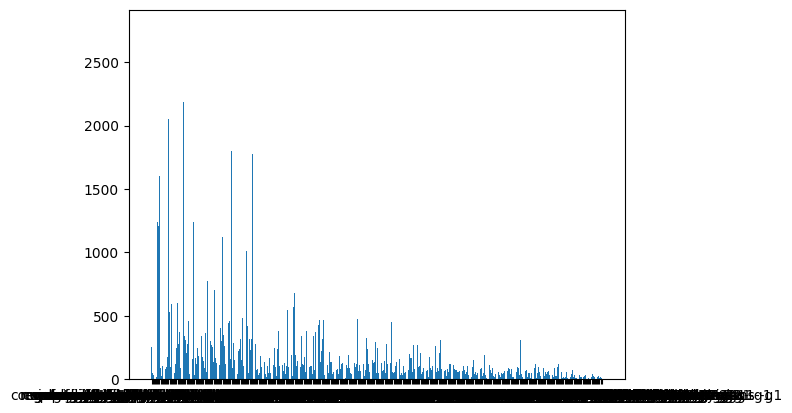

In [9]:
print("Images - total: {}".format(total))
print("Images - rejected: {}".format(rejected) + " ({:.2f}%)".format(rejected / total * 100))
print("Signs: {}".format(np.sum(sign_distr.values())))
for ix, value in sign_distr.items():
    print(f"{labels[ix]}: {value}")

# remove 'other-label' from statistics
sign_distr_cpy = sign_distr.copy()
sign_distr_cpy[3] = 0 # other-label
plt.bar(labels, sign_distr_cpy.values())